<font size = "5"> **EDS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectrum Images
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS-SI.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS-SI.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.

Unlike in an EELS spectrum, a single pixel in an EDS spectrum image does not contain enough information to quantify the chemical composition or even detect trace elements. 

Several different stategies will be explored in this notebook of how to analyze these kind of data.
 

## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2025.12.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install pyTEMlib --upgrade
# ------------------------------
print('done')

installing pyTEMlib
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ----------------------------------- ---- 1.3/1.5 MB 13.1 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 8.2 MB/s  0:00:00
  Attempting uninstall: pyTEMlib
    Found existing installation: pyTEMlib 0.2025.11.3
    Uninstalling pyTEMlib-0.2025.11.3:
      Successfully uninstalled pyTEMlib-0.2025.11.3
done


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycrosgui 0.2.2 requires pyqt5, which is not installed.
pytemgui 0.2.2 requires pyqt5, which is not installed.


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [3]:
%matplotlib widget
import sys
import numpy as np
import matplotlib.pylab as plt

# using  pyTEMlib.eds_tools, pyTEMlib.file_tools and pyTEMlib.eels_tools (for line definitions)

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../../')
import pyTEMlib

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'EDS_Spectrum_Analysis'
__notebook_version__ = '2025_10_27'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
pyTEM version:  0.2026.1.0


## Open File

### Load File

Select a main dataset and any additional data like reference data and such.
Go to open and plot dataset for more explanations ()

In [4]:
import SciFiReaders
SciFiReaders()
SciFiReaders.EMDReader.read(eds_stream=True)

Help on function read in module SciFiReaders.readers.microscopy.em.tem.emd_reader:

read(self, eds_stream: bool = False, bin_xy: int = 2)
    Reads all available datasets in FEI Velox style hdf5 files with .edm

    Parameters
    ----------
    eds_stream: boolean
        switch to return spectrum image (default - False) or original spectrum stream (True)
    bin_xy: int
        binning factor for EDS spectrum size reduction

    Returns
    -------
    datasets: list of sidpy.Dataset objects
        Datasets present in the provided file



In [4]:
#path =  "C:\Users\gduscher\OneDrive - University of Tennessee\google_drive\2022 Experiments\Spectra\20221214\AlCe-200kV"
fileWidget = pyTEMlib.file_tools.FileWidget()

### Select and Plot Dataset

Select a dataset from the drop down menu above and display it with the code cell below.

Here we sum the spectra of the 4 quadrants and define the detector parameter.

In [5]:
import sidpy
fileWidget = sidpy.FileWidget()

In [5]:
dataset = fileWidget.selected_dataset
view = dataset.plot()
print(dataset)
dataset

NameError: name 'fileWidget' is not defined

Clicking on the image will show the coordinates of the pixel clicked and displays that spectrum. 

>One sees that the spectra contain too little counts for a meaningful analysis. 
>To improve the statistics we will sum up spectra from a region of interest (ROI).
>
>> Different stategies for this summation will be explored below.

### Rigid Registration and Atom Finding
Select the Image stack

In [4]:
chooser = pyTEMlib.file_tools.ChooseDataset(fileWidget.datasets)

Dropdown(description='select dataset:', options=('Channel_000: Mn', 'Channel_001: Mg', 'Channel_002: Ni', 'Cha…

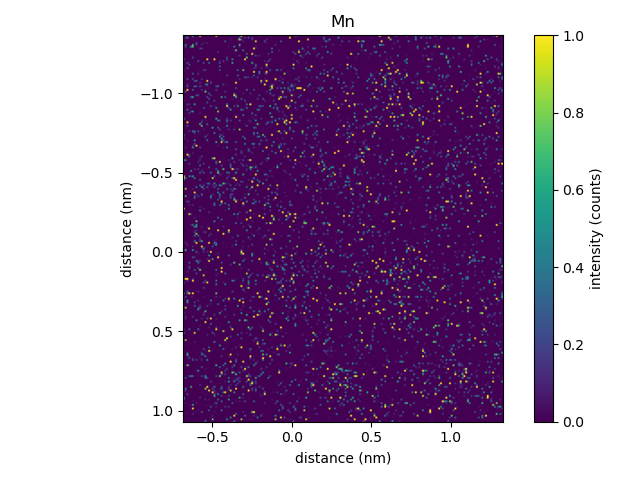

In [10]:
v = chooser.dataset.plot()

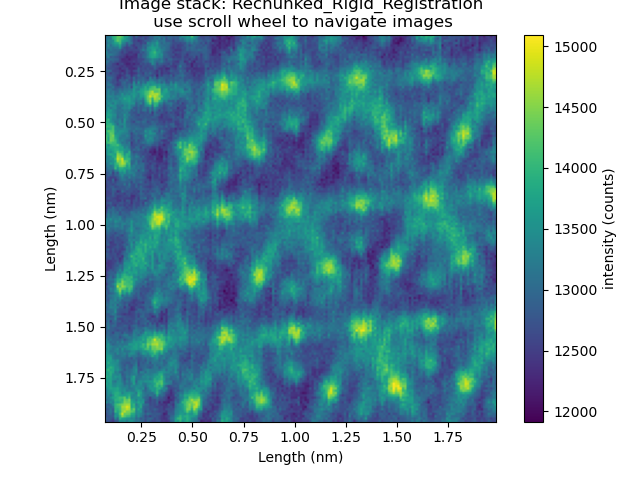

In [5]:
haadf = chooser.dataset
rigid_registered = pyTEMlib.image_tools.rigid_registration(haadf)
v = rigid_registered.plot()

Visualize Drift

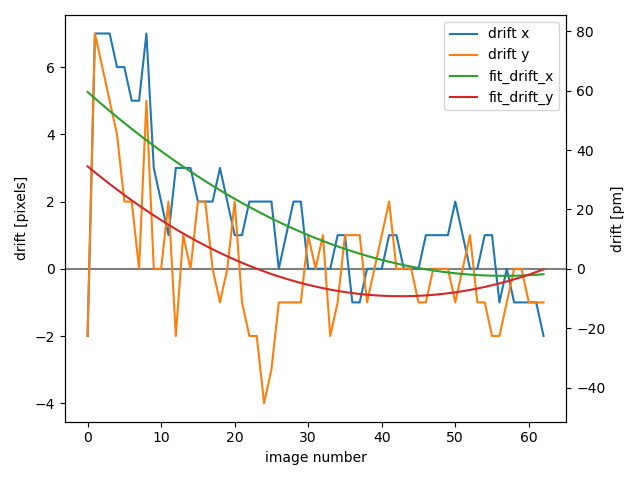

In [6]:
drift = rigid_registered.metadata['analysis']['rigid_registration']['drift']
polynom_degree = 2 # 1 is linear fit, 2 is parabolic fit, ...

x = np.linspace(0,drift.shape[0]-1,drift.shape[0])

line_fit_x = np.polyfit(x, drift[:,0], polynom_degree)
poly_x = np.poly1d(line_fit_x)
line_fit_y = np.polyfit(x, drift[:,1], polynom_degree)
poly_y = np.poly1d(line_fit_y)

plt.figure()
plt.axhline(color = 'gray')
plt.plot(x, drift[:,0], label = 'drift x')
plt.plot(x, drift[:,1], label = 'drift y')
plt.plot(x, poly_x(x),  label = 'fit_drift_x')
plt.plot(x, poly_y(x),  label = 'fit_drift_y')

plt.legend();
ax_pixels = plt.gca()
ax_pixels.step(1, 1)

scaleX = (rigid_registered.x[1]-rigid_registered.x[0])*1000.  #in pm

ax_pm = ax_pixels.twinx()
x_1, x_2 = ax_pixels.get_ylim()

ax_pm.set_ylim(x_1*scaleX, x_2*scaleX)

ax_pixels.set_ylabel('drift [pixels]')
ax_pm.set_ylabel('drift [pm]')
ax_pixels.set_xlabel('image number');
plt.tight_layout()

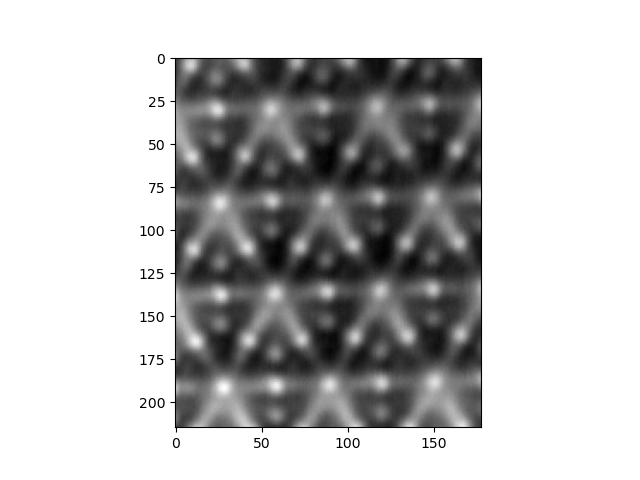

In [11]:
haadf_sum = haadf.sum(axis=0)
haadf_sum.data_type = 'image'
plt.figure()
plt.imshow(haadf_sum.T, cmap='gray');

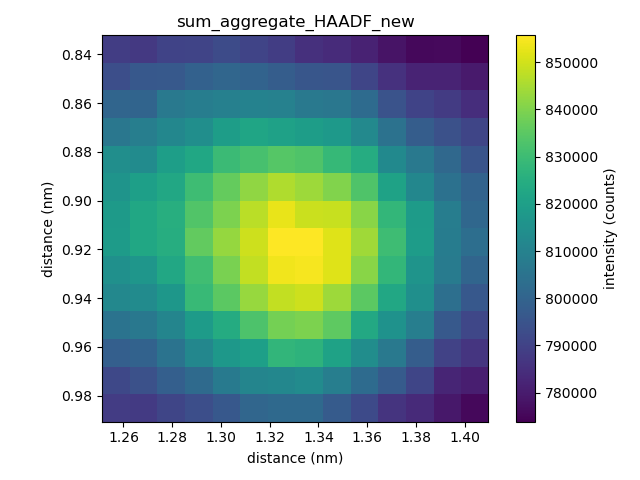

In [15]:
width = 14
position = np.array([118,81])-int(width/2)
atom = haadf_sum[position[0]:position[0]+width, position[1]:position[1]+width]
atom.data_type = 'image'
atom.plot();

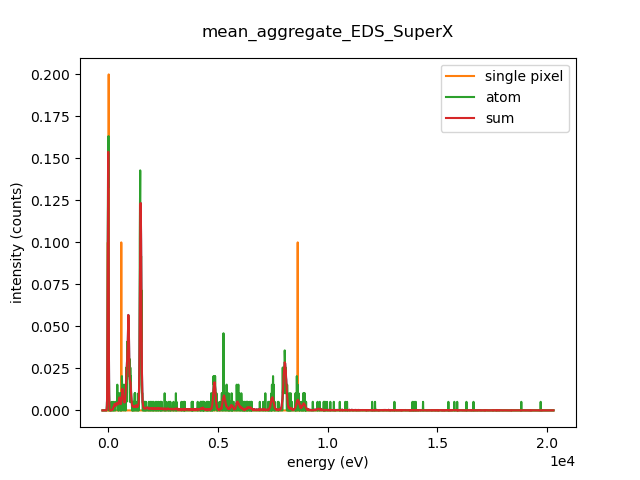

In [16]:
atom_sum = dataset[position[0]:position[0]+width, position[1]:position[1]+width]
atom_sum= atom_sum.mean(axis=(0,1))

spectrum_sum = dataset.mean(axis=(0,1))
spectrum_sum.data_type = 'spectrum'
view = spectrum_sum.plot();
plt.gca().plot(spectrum_sum.energy_scale.values, np.array(dataset[118, 81])/10, label='single pixel');  
plt.gca().plot(spectrum_sum.energy_scale.values, atom_sum, label='atom')
plt.gca().plot(spectrum_sum.energy_scale.values, spectrum_sum, label='sum')
plt.gca().legend();

This is a clear demonstration that even the sum over a single atom will not give a good statistic in the EDS spectra 

In [38]:
dataset.view_metadata()

experiment :
	detector : SuperXG21
	acceleration_voltage : 200000.0
	microscope : Titan
	start_date_time : 1671044532
	collection_angle : -1.0
	convergence_angle : 0.03
	probe_mode : convergent
	stage :
		holder : 
		position :
			x : -0.0004458012750000001
			y : 0.00041000946000000014
			z : -5.289224220235313e-05
		tilt :
			alpha : 0.12116822300000002
			beta : 0.08483282720148563
	instrument : Spectra4018
	current : 6.9062810780693e-11
	pixel_time : 5e-05
	exposure_time : 2.2339
	collection_angle_end : -1.0
EDS :
	detector :
		layers :
			13 :
				thickness : 5e-08
				Z : 13
				element : Al
		SiDeadThickness : 1.3e-07
		SiLiveThickness : 0.05
		detector_area : 2.9999999999999997e-05
		energy_resolution : 125
		start_energy : 120
		start_channel : 100
		ElevationAngle : 0.31415927
		AzimuthAngle : 0.7853981633974483
		RealTime : 1.927908375
		LiveTime : 1.912787525
filename : C:\Users\gduscher\OneDrive - University of Tennessee\google_drive\2022 Experiments\Spectra\20221214\AlCe-

In [46]:
### Does not work for spectrum images
# 
spectrum = dataset.sum(axis=(0,1))
spectrum.data_type = 'spectrum'
start = np.searchsorted(spectrum.energy_scale.values, 100)
energy_scale = spectrum.energy_scale.values[start:]
detector_Efficiency= pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])
if 'start_energy' not in spectrum.metadata['EDS']['detector']:
    spectrum.metadata['EDS']['detector']['start_energy'] = 120
spectrum[:np.searchsorted(spectrum.energy_scale.values,spectrum.metadata['EDS']['detector']['start_energy'])] = 0.
spectrum.metadata['EDS']['detector']['detector_efficiency']  = detector_Efficiency

## Find Elements 

c:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\array\core.py:1738: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
C:\Users\gduscher\AppData\Local\Temp\ipykernel_5660\2690851649.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


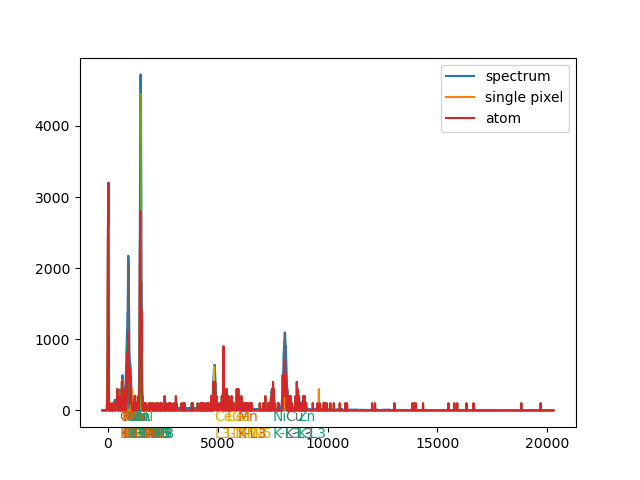

In [47]:
# --------Input -----------
minimum_number_of_peaks = 10
# --------------------------
import scipy
pyTEMlib.eds_tools.get_elements(spectrum, minimum_number_of_peaks, verbose=False)
atom_sum = dataset[position[0]:position[0]+width, position[1]:position[1]+width]
atom_sum= atom_sum.sum(axis=(0,1))
# atom_sum = scipy.ndimage.gaussian_filter1d(atom_sum, sigma=3)
single = dataset[87,84]
plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.gca().plot(spectrum_sum.energy_scale.values, np.array(single)*300, label='single pixel');  
plt.gca().plot(spectrum_sum.energy_scale.values, atom_sum*100)
plt.gca().plot(spectrum_sum.energy_scale.values, atom_sum*100, label='atom')
#plt.gca().plot(spectrum_sum.energy_scale.values, spectrum, label='sum')
plt.legend();



In [48]:
### Add Mg
def add_element(spectrum, elements):
    if isinstance(elements, str):
        elements = [elements]
    if not isinstance(elements, list):
        raise ValueError("elements must be a string or a list of strings")
    spectrum.metadata['EDS'].update(pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements))

add_element(spectrum, 'Mg')   
spectrum.metadata['EDS']['Mg']                                                               

{'Z': 12,
 'K-family': {'lines': ['K-L3', 'K-L2'],
  'main': 'K-L3',
  'weight': 1.0,
  'height': np.float64(90.0),
  'K-L3': {'weight': 1.0, 'position': 1253.6},
  'K-L2': {'weight': 0.507, 'position': 1253.6}}}

In [49]:
out_string = 'Found Elements: '
for key in spectrum.metadata['EDS']:
    if len(key) <3: 
        out_string += f'{key}, ' 
print(out_string)

Found Elements: Al, Ce, O, Cu, Ni, Mn, Zn, F, Mg, 


Viziualization what happens at the atomic scale.

We plot the difference between the atom signal and the total signal of the spectrum-image 
 

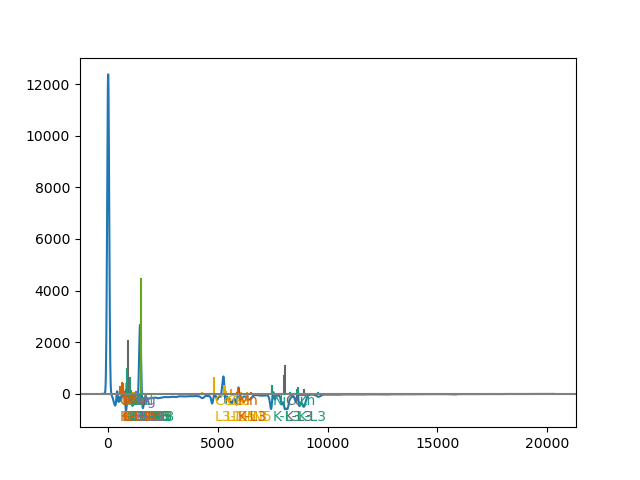

In [50]:
atom_sum = dataset[position[0]:position[0]+width, position[1]:position[1]+width]
atom_sum= atom_sum.sum(axis=(0,1))
atom_sum = scipy.ndimage.gaussian_filter1d(atom_sum, sigma=3)   
spectrum_ref = spectrum/spectrum.sum()*atom_sum.sum()
spectrum_ref = scipy.ndimage.gaussian_filter1d(spectrum_ref, sigma=3)
difference = atom_sum - spectrum_ref
difference = difference -np.mean(difference)
#difference[difference < 0] = 0
difference = scipy.ndimage.gaussian_filter1d(difference, sigma=3)
plt.figure()
plt.plot(spectrum.energy_scale,difference*1000, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(0, color='gray')


## Quantify

### Fit spectrum
Fitting the spectrum with Gaussians and a Background

In [51]:
spectrum = dataset.sum(axis=(0,1))
spectrum.data_type = 'spectrum'
atom_sum = dataset[position[0]:position[0]+width, position[1]:position[1]+width]
atom_sum = atom_sum.sum(axis=(0,1))
atom_sum = scipy.ndimage.gaussian_filter1d(atom_sum, sigma=3)
spectrum_atom = spectrum.like_data(atom_sum).copy()
spectrum_atom.data_type = 'spectrum'

no intensity Ce M-family


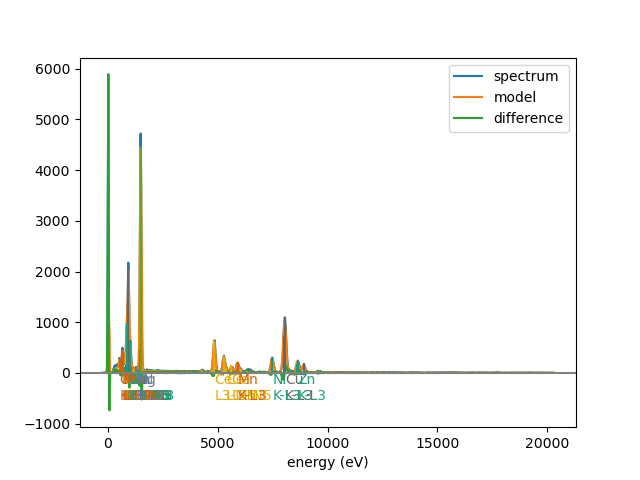

In [52]:
import pyTEMlib.eds_tools
peaks, pp = pyTEMlib.eds_tools.fit_model(spectrum, use_detector_efficiency=True)
model = pyTEMlib.eds_tools.get_model(spectrum)

plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, np.array(spectrum-model), label='difference')
plt.xlabel('energy (eV)')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.legend()

### Quantify Spectrum
first with Bote-Salvat cross section
using dictionaries calculated with [emtables package](https://github.com/adriente/emtables/blob/main/).

In [53]:
pyTEMlib.eds_tools.quantify_eds(spectrum, mask=[])

using cross sections for quantification
Al: 50.91 at% 28.43 wt%
Ce: 9.21 at% 26.71 wt%
Cu: 20.39 at% 26.82 wt%
Mn: 2.74 at% 3.12 wt%
Zn: 4.51 at% 6.11 wt%
Ni: 5.00 at% 6.08 wt%
Mg: 0.61 at% 0.31 wt%
O : 2.82 at% 0.93 wt%
F : 3.81 at% 1.50 wt%


then with k-factor dictionary

In [54]:
print('whole spectrum-image')

q_dict = pyTEMlib.eds_tools.load_k_factors()
tags = pyTEMlib.eds_tools.quantify_eds(spectrum, q_dict, mask = [])
print(spectrum.metadata['EDS']['GUI'])

print('\n single_atom')
# peaks2, pp2 = pyTEMlib.eds_tools.fit_model(spectrum_atom, use_detector_efficiency=True)
# model2 = pyTEMlib.eds_tools.get_model(spectrum_atom)

# tags2 = pyTEMlib.eds_tools.quantify_eds(spectrum_atom, q_dict, mask = [])
# print(spectrum.metadata['EDS']['GUI'])

whole spectrum-image
using L k-factor for Ce
using k-factors for quantification
Al: 55.57 at% 34.34 wt%
Ce: 6.56 at% 21.03 wt%
O : 3.68 at% 1.35 wt%
Cu: 17.75 at% 25.84 wt%
Ni: 4.41 at% 5.93 wt%
Mn: 2.51 at% 3.16 wt%
Zn: 3.90 at% 5.83 wt%
F : 4.93 at% 2.15 wt%
Mg: 0.69 at% 0.38 wt%
excluded from quantification  []
{'Al': {'symmetry': 'K-family', 'atom%': np.float64(55.57101162209383), 'weight%': np.float64(34.335477854684974), 'excluded': False, 'k_factor': 0.330728, 'intensity': np.float64(41048.82103182718)}, 'Ce': {'symmetry': 'L-family', 'atom%': np.float64(6.555195911537163), 'weight%': np.float64(21.03364343841367), 'excluded': False, 'k_factor': 0.531928, 'intensity': np.float64(15634.723772788473)}, 'Cu': {'symmetry': 'K-family', 'atom%': np.float64(17.75464745141047), 'weight%': np.float64(25.836220037181008), 'excluded': False, 'k_factor': 0.513247, 'intensity': np.float64(19903.5760208229)}, 'Mn': {'symmetry': 'K-family', 'atom%': np.float64(2.5097844526595905), 'weight%': n

In [23]:
tags = pyTEMlib.eds_tools.quantify_eds(spectrum, q_dict, mask = [])


using L k-factor for Ce
using k-factors for quantification
Mn: 2.67 at% 3.26 wt%
Ni: 3.64 at% 4.75 wt%
Ce: 7.74 at% 24.09 wt%
Al: 65.92 at% 39.50 wt%
Zn: 3.62 at% 5.25 wt%
Cu: 16.41 at% 23.15 wt%
excluded from quantification  []


### Absorption Correction
Lower energy lines will be more affected than higher x-ray lines.

At thin sample location (<50nm) absorption is not significant.

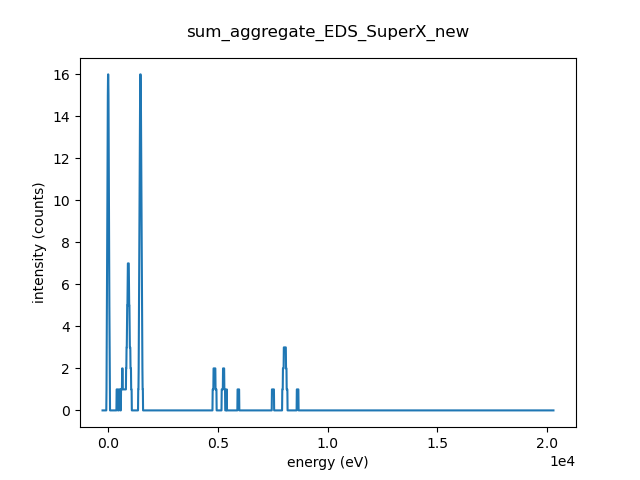

In [58]:
v = spectrum_atom.plot()

In [57]:
# ------ Input ----------
thickness_in_nm = 150
# -----------------------
pyTEMlib.eds_tools.apply_absorption_correction(spectrum, thickness_in_nm)
for key, value in spectrum.metadata['EDS']['GUI'].items():
    if 'corrected-atom%' in value:
        print(f"Element: {key}, Corrected Atom%: {value['corrected-atom%']:.2f}, Corrected Weight%: {value['corrected-weight%']:.2f}")

Element: Al, Corrected Atom%: 56.40, Corrected Weight%: 35.34
Element: Ce, Corrected Atom%: 6.34, Corrected Weight%: 20.65
Element: Cu, Corrected Atom%: 17.16, Corrected Weight%: 25.32
Element: Mn, Corrected Atom%: 2.43, Corrected Weight%: 3.10
Element: Zn, Corrected Atom%: 3.77, Corrected Weight%: 5.72
Element: Ni, Corrected Atom%: 4.26, Corrected Weight%: 5.81
Element: Mg, Corrected Atom%: 0.72, Corrected Weight%: 0.40
Element: O, Corrected Atom%: 3.87, Corrected Weight%: 1.44
Element: F, Corrected Atom%: 5.06, Corrected Weight%: 2.23


## Find Atoms


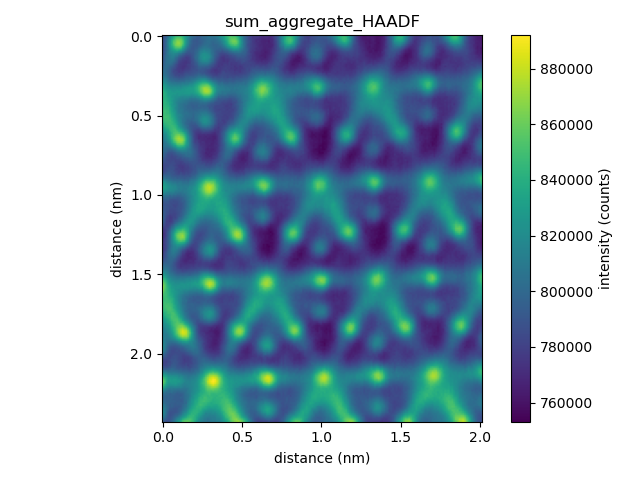

In [60]:
v = haadf_sum.plot()

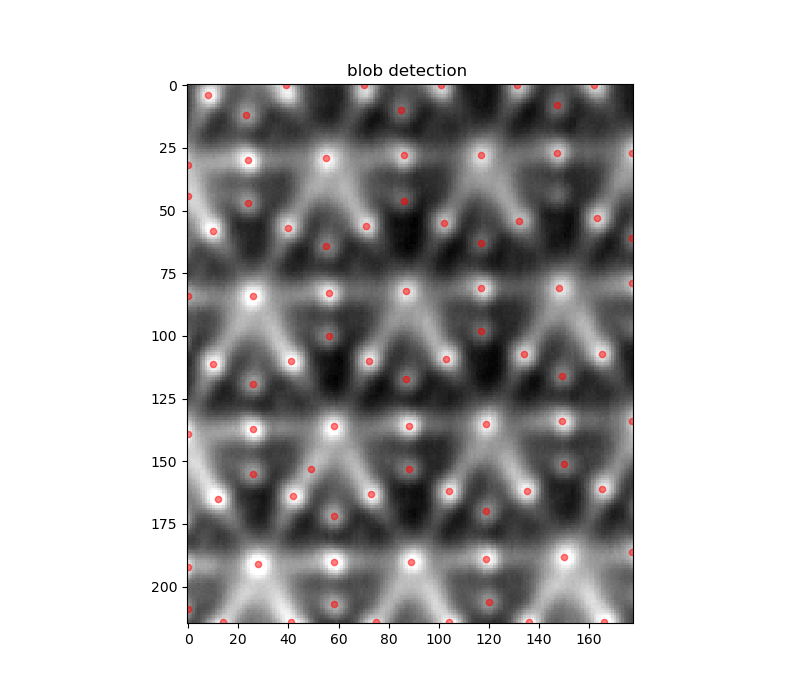

In [90]:
import skimage
# ------- Input ------
threshold = 1.5 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = .05 #in nm  
# ----------------------


image = haadf_sum/haadf_sum.max()*100
image -= image.min()
scale_x = image.get_image_dims(return_axis=True)[0].slope
#image = image_choice.dataset
# scale_x = pyTEMlib.file_tools.get_slope(image.dim_1)
blobs = None
blobs =  skimage.feature.blob_log(image, max_sigma=atom_size/scale_x, threshold=threshold)

fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

  0%|          | 0/215 [00:00<?, ?it/s]

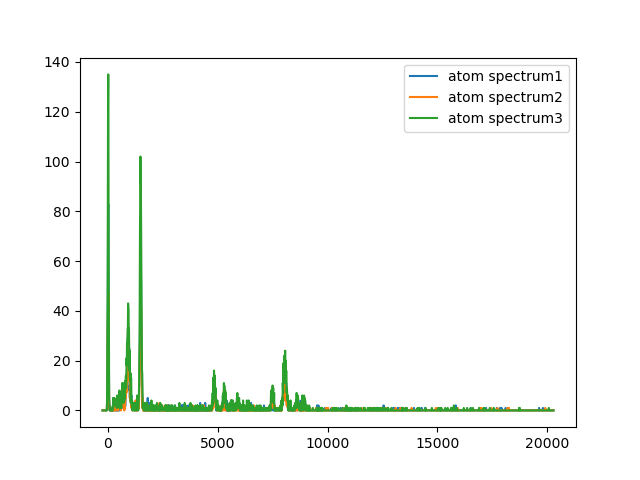

In [116]:
from tqdm.notebook import trange

neighbor_tree = scipy.spatial.KDTree(blobs[:, :2])
data_array = np.array(dataset)
atom_spectra = np.zeros([len(blobs), dataset.shape[2]])
for x in trange(image.shape[1]):
    for y in range(image.shape[0]):
        index = neighbor_tree.query([x,y])[1]
        atom_spectra[int(index)] += data_array[x,y]

plt.figure()
plt.plot(spectrum.energy_scale, atom_spectra[18], label='atom spectrum1')
plt.plot(spectrum.energy_scale, atom_spectra[57], label='atom spectrum2')
plt.plot(spectrum.energy_scale, atom_spectra[38], label='atom spectrum3')
plt.legend()

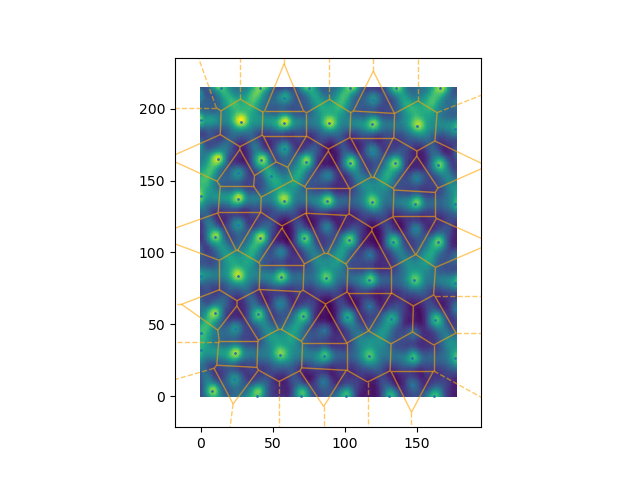

In [110]:
voronoi =scipy.spatial.Voronoi(blobs[:, :2])
plt.figure()
plt.imshow(image.T)
scipy.spatial.voronoi_plot_2d(voronoi, plt.gca(), show_vertices=False, line_colors='orange', line_width=1, line_alpha=0.6, point_size=2);

## Summary
The spectrum is modeled completely with background and characteristic peak-families.

Either 
- k-factors in a file (here from Spectra300) or
- Bothe-Salvat cross-sections
 
are used for quantification.

## Appendix
### Background
The determined background used for the model-based quantification is based on the detector effciency.

Note:

The detector efficiency is also used for the quantification model.
